All imports

In [60]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
from torchvision import models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image
from tqdm import tqdm

Dataset and Dataloaders

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, images_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transform = transform
        self.classes = list(self.labels_df.columns[1:])
        
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 0]
        
        img_path = os.path.join(self.images_dir, img_name)
        
        image = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            image_t = self.transform(image)
        else:
            image_t = transforms.ToTensor()(image)
        
        labels = self.labels_df.iloc[idx, 1:7].values.astype(np.float32)
        label_idx = np.argmax(labels)
        
        return image_t, label_idx
    
    def get_class_distribution(self):
        class_counts = self.labels_df.iloc[:, 1:].sum().to_dict()

        return class_counts
    

def create_data_loaders(data_dir='data', batch_size=32):

    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = CustomDataset(
        csv_file=os.path.join(data_dir, 'train', '_classes.csv'),
        images_dir=os.path.join(data_dir, 'train'),
        transform=train_transform
    )
    
    val_dataset = CustomDataset(
        csv_file=os.path.join(data_dir, 'valid', '_classes.csv'),
        images_dir=os.path.join(data_dir, 'valid'),
        transform=val_transform
    )
    
    test_dataset = CustomDataset(
        csv_file=os.path.join(data_dir, 'test', '_classes.csv'),
        images_dir=os.path.join(data_dir, 'test'),
        transform=val_transform
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    print(f"Dataset sizes:")
    print(f"Train: {len(train_dataset)} samples")
    print(f"Validation: {len(val_dataset)} samples")
    print(f"Test: {len(test_dataset)} samples")
    
    return train_loader, val_loader, test_loader, train_dataset.classes

train_loader, val_loader, test_loader, classes = create_data_loaders()

Dataset sizes:
Train: 1767 samples
Validation: 504 samples
Test: 253 samples


CNN model

In [62]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        with torch.no_grad():
            sample_input = torch.zeros(1, 3, 224, 224)
            conv_out = self.conv_layers(sample_input)
            num_features = conv_out.view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

ResNet model

In [63]:
def custom_resnet(num_classes=6, pretrained=True, freeze_backbone=True):
    model = models.resnet18(pretrained=pretrained)
    if freeze_backbone:
        for p in model.parameters():
            p.requires_grad = False
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    return model

Train, test and validate functions

In [64]:
def train_step(model, train_loader, optimizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    return train_loss, train_acc


def validate(model, val_loader, device=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    
    return val_loss, val_acc


def test_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    
    return test_loss, test_acc

Plot training history function

In [65]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(train_losses, label='Train Loss', linewidth=2)
    ax1.plot(val_losses, label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(train_accs, label='Train Accuracy', linewidth=2)
    ax2.plot(val_accs, label='Val Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=100, bbox_inches='tight')
    plt.show()

Main code

c:\Users\jakub\anaconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jakub\anaconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\jakub\anaconda3\envs\ml\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model loaded on cuda
Starting Training


Training: 100%|██████████| 56/56 [00:14<00:00,  3.91it/s]




Epoch 1 Summary:
Train Loss: 1.2922, Train Acc: 49.35%
Val Loss: 0.8264, Val Acc: 72.62%
✓ New best model saved! Val Acc: 72.62%
----------------------------------------


Training: 100%|██████████| 56/56 [00:13<00:00,  4.17it/s]




Epoch 2 Summary:
Train Loss: 0.8220, Train Acc: 70.06%
Val Loss: 0.6858, Val Acc: 75.20%
✓ New best model saved! Val Acc: 75.20%
----------------------------------------


Training: 100%|██████████| 56/56 [00:13<00:00,  4.02it/s]




Epoch 3 Summary:
Train Loss: 0.7143, Train Acc: 73.12%
Val Loss: 0.5977, Val Acc: 80.75%
✓ New best model saved! Val Acc: 80.75%
----------------------------------------


Training: 100%|██████████| 56/56 [00:14<00:00,  3.99it/s]




Epoch 4 Summary:
Train Loss: 0.6968, Train Acc: 75.72%
Val Loss: 0.5691, Val Acc: 80.95%
✓ New best model saved! Val Acc: 80.95%
----------------------------------------


Training: 100%|██████████| 56/56 [00:14<00:00,  3.83it/s]




Epoch 5 Summary:
Train Loss: 0.5966, Train Acc: 77.42%
Val Loss: 0.5382, Val Acc: 81.15%
✓ New best model saved! Val Acc: 81.15%
----------------------------------------


Training: 100%|██████████| 56/56 [00:13<00:00,  4.19it/s]




Epoch 6 Summary:
Train Loss: 0.6125, Train Acc: 78.27%
Val Loss: 0.5388, Val Acc: 80.16%
No improvement for 1 epoch(s)
----------------------------------------


Training: 100%|██████████| 56/56 [00:13<00:00,  4.14it/s]




Epoch 7 Summary:
Train Loss: 0.5497, Train Acc: 79.74%
Val Loss: 0.5063, Val Acc: 81.94%
✓ New best model saved! Val Acc: 81.94%
----------------------------------------


Training: 100%|██████████| 56/56 [00:14<00:00,  3.77it/s]




Epoch 8 Summary:
Train Loss: 0.5199, Train Acc: 80.76%
Val Loss: 0.5828, Val Acc: 81.15%
No improvement for 1 epoch(s)
----------------------------------------


Training: 100%|██████████| 56/56 [00:13<00:00,  4.10it/s]




Epoch 9 Summary:
Train Loss: 0.5347, Train Acc: 81.32%
Val Loss: 0.4766, Val Acc: 83.73%
✓ New best model saved! Val Acc: 83.73%
----------------------------------------


Training: 100%|██████████| 56/56 [00:13<00:00,  4.08it/s]




Epoch 10 Summary:
Train Loss: 0.5233, Train Acc: 81.78%
Val Loss: 0.5045, Val Acc: 82.94%
No improvement for 1 epoch(s)
----------------------------------------


Training: 100%|██████████| 56/56 [00:13<00:00,  4.13it/s]




Epoch 11 Summary:
Train Loss: 0.5090, Train Acc: 81.72%
Val Loss: 0.4456, Val Acc: 83.93%
✓ New best model saved! Val Acc: 83.93%
----------------------------------------


Training: 100%|██████████| 56/56 [00:13<00:00,  4.09it/s]




Epoch 12 Summary:
Train Loss: 0.4806, Train Acc: 83.31%
Val Loss: 0.4712, Val Acc: 84.13%
✓ New best model saved! Val Acc: 84.13%
----------------------------------------


Training: 100%|██████████| 56/56 [00:13<00:00,  4.08it/s]




Epoch 13 Summary:
Train Loss: 0.4197, Train Acc: 85.06%
Val Loss: 0.4522, Val Acc: 84.13%
No improvement for 1 epoch(s)
----------------------------------------


Training: 100%|██████████| 56/56 [00:14<00:00,  3.88it/s]




Epoch 14 Summary:
Train Loss: 0.4565, Train Acc: 83.47%
Val Loss: 0.4779, Val Acc: 83.13%
No improvement for 2 epoch(s)
----------------------------------------


Training: 100%|██████████| 56/56 [00:14<00:00,  3.82it/s]




Epoch 15 Summary:
Train Loss: 0.4029, Train Acc: 85.23%
Val Loss: 0.4450, Val Acc: 84.52%
✓ New best model saved! Val Acc: 84.52%
----------------------------------------


Training: 100%|██████████| 56/56 [00:13<00:00,  4.00it/s]




Epoch 16 Summary:
Train Loss: 0.3720, Train Acc: 86.98%
Val Loss: 0.4298, Val Acc: 85.32%
✓ New best model saved! Val Acc: 85.32%
----------------------------------------


Training: 100%|██████████| 56/56 [00:13<00:00,  4.09it/s]




Epoch 17 Summary:
Train Loss: 0.3330, Train Acc: 88.17%
Val Loss: 0.4196, Val Acc: 85.32%
No improvement for 1 epoch(s)
----------------------------------------


Training: 100%|██████████| 56/56 [00:14<00:00,  3.79it/s]




Epoch 18 Summary:
Train Loss: 0.3543, Train Acc: 87.55%
Val Loss: 0.4318, Val Acc: 84.72%
No improvement for 2 epoch(s)
----------------------------------------


Training: 100%|██████████| 56/56 [00:16<00:00,  3.48it/s]




Epoch 19 Summary:
Train Loss: 0.3342, Train Acc: 88.62%
Val Loss: 0.4430, Val Acc: 85.12%
No improvement for 3 epoch(s)
----------------------------------------


Training: 100%|██████████| 56/56 [00:15<00:00,  3.72it/s]




Epoch 20 Summary:
Train Loss: 0.3645, Train Acc: 86.87%
Val Loss: 0.4320, Val Acc: 84.13%
No improvement for 4 epoch(s)
----------------------------------------

Training Complete

Loading best model for testing...


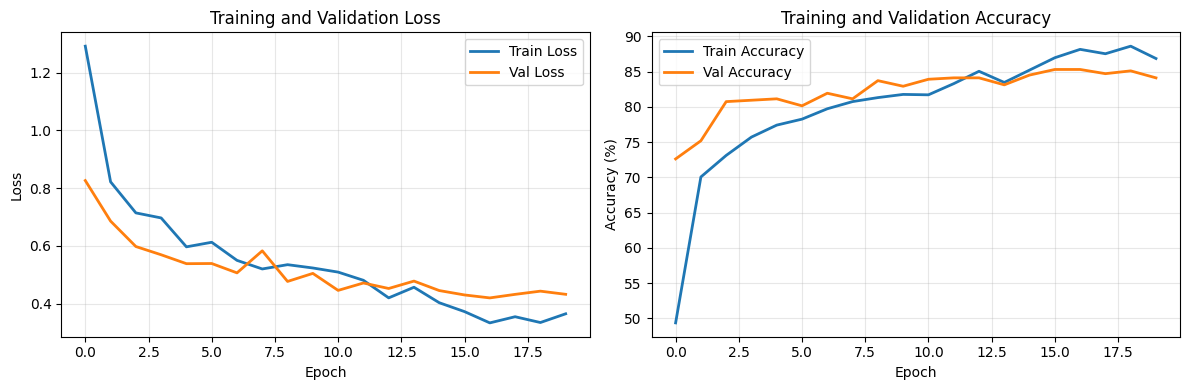


Model saved as:
1. 'best_model.pth' - Best checkpoint
2. 'final_model.pth' - Final model
4. 'training_history.png' - Training plots


In [ ]:
# =====================
# MODEL SETUP
# =====================
model = custom_resnet(num_classes=6, pretrained=True, freeze_backbone=True)
#model = SimpleCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Model loaded on {device}")

# =====================
# TRAINING CONFIG
# =====================
num_epochs = 20
best_val_acc = 0.0
patience = 5
patience_counter = 0

print("="*60)
print("Starting Training")
print("="*60)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=1e-6)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

# =====================
# TRAINING LOOP
# =====================
for epoch in range(num_epochs):
    train_loss, train_acc = train_step(model, train_loader, optimizer=optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
        
    val_loss, val_acc = validate(model, val_loader, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_loss)
        
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
            
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'val_acc': val_acc,
            'train_acc': train_acc,
            'num_classes': 6,
            'class_names': ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
        }, 'best_model.pth')
            
        print(f"✓ New best model saved! Val Acc: {val_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s)")
        
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break
        
    print("-" * 40)
    
# ====================
# FINAL EVALUATION
# ==================== 
print("\n" + "="*60)
print("Training Complete")
print("="*60)
    
print("\nLoading best model for testing...")
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
    
test_loss, test_acc = test_model(model, test_loader)
    
plot_training_history(train_losses, val_losses, train_accs, val_accs)
    
# ====================
# SAVE FINAL MODEL 
# ====================
torch.save(model, 'final_model.pth')
    
print("\n" + "="*60)
print("Model saved as:")
print("1. 'best_model.pth' - Best checkpoint")
print("2. 'final_model.pth' - Final model")
print("4. 'training_history.png' - Training plots")
print("="*60)

# ====================
# INFERENCE FUNCTION 
# ====================
def predict_single_image(model_path, image_path, class_names=None, device='cpu'):
    """Predict a single image"""
    
    if model_path.endswith('.pth'):
        checkpoint = torch.load(model_path, map_location=device)
        model = custom_resnet()
        model.load_state_dict(checkpoint['model_state_dict'])
        if class_names is None:
            class_names = checkpoint.get('class_names', None)
    else:
        model = torch.load(model_path, map_location=device)
    
    model = model.to(device)
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()
        confidence = probabilities[predicted_class].item()
    
    if class_names is not None and predicted_class < len(class_names):
        class_name = class_names[predicted_class]
    else:
        class_name = f"Class {predicted_class}"
    
    top3_probs, top3_indices = torch.topk(probabilities, 3)
    
    print(f"\nPrediction for: {image_path}")
    print(f"Predicted: {class_name} (Confidence: {confidence:.2%})")
    print("\nTop 3 predictions:")
    for i, (idx, prob) in enumerate(zip(top3_indices, top3_probs)):
        cls_name = class_names[idx] if class_names else f"Class {idx}"
        print(f"{i+1}. {cls_name}: {prob:.2%}")
    
    return predicted_class, confidence

In [67]:
pred_class, conf = predict_single_image('best_model.pth', 'data/test/glass1_jpg.rf.0deb56d6bc8aac5826e45156c841fb85.jpg', class_names=classes, device=device)


Prediction for: data/test/glass1_jpg.rf.0deb56d6bc8aac5826e45156c841fb85.jpg
Predicted: glass (Confidence: 91.96%)

Top 3 predictions:
1. glass: 91.96%
2. metal: 7.32%
3. plastic: 0.39%
